In [35]:
import numpy
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import seaborn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

recrutamento = pd.read_csv('recruitment_data.csv', sep=',', decimal='.')


# Instanciando o objeto One-Hot encoder, pois vai ser utilizada na coluna recrutamento Strategy
ohe = OneHotEncoder(handle_unknown='ignore')
# Fazendo a transformação
ohe_df = pd.DataFrame(ohe.fit_transform(recrutamento[['RecruitmentStrategy']]).toarray(), columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3'])

# Agrupando a nova coluna com o df original
df = recrutamento.join(ohe_df)

recrutamento = df.drop(['RecruitmentStrategy'], axis=1)

features = list(recrutamento.columns.values)

classificacao = 'HiringDecision'

corrKendall = recrutamento.corr('kendall')

corrPearson = recrutamento.corr('pearson')

corrSpearman = recrutamento.corr('spearman')

tabela_correlacoes = pd.DataFrame()

tabela_correlacoes['kendal']= corrKendall['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['pearson']= corrPearson['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['spearman']= corrSpearman['HiringDecision'].sort_values(ascending=False)

tabela_correlacoes.drop(tabela_correlacoes[tabela_correlacoes['kendal']==1].index, inplace=True)
#Verifica-se que a estrategia de recrutamento  =1 que eh a agressiva, vai impactar muito na decisao final de contratacao

#removendo as features que tiveram indice de correlacao menor que 0.1
#tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

#relacoes_excluidas = tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

#features = [i for i in features if i not in relacoes_excluidas]

features.remove('PreviousCompanies')
features.remove('Age')
features.remove('Gender')
features.remove('DistanceFromCompany')
#Remove o output
features.remove(classificacao)

X = recrutamento[features].to_numpy() 
Y = recrutamento[classificacao].to_numpy() 


# Normalizando as features X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_normalizado_standard = X_scaler.transform(X)


scaler = MinMaxScaler()
scaler = scaler.fit(X)
X_normalizado_min_max = scaler.transform(X)


X_transformado= X_normalizado_standard

#seaborn.scatterplot(X_normalizado_min_max) #melhor pois tem features que tem escala diferente 



Num GPUs Available:  1


In [36]:
# PARAMETROS DA REDE 
maximo_neuronios = 5
funcoes_ativacao = ['tanh', 'relu', 'sigmoid'] 
metrica = 'Accuracy' 
#quantidade de loops q vai esperar ate q o erro de teste comece a aumentar 
paciencia = 150
max_epocas =3*paciencia
min_improvement = 0.01
adam_initial_lr = 0.01
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True #se comecar o erro a subir, volta pra onde tava bom

# SEED que controla a aleatoriedade 
random_seed = 22
n_k_folds = 5 #quantas partes o dataset vai ser dividido
keras.utils.set_random_seed(random_seed)
# DIVIDE EM K PEDACOS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_transformado, Y)

5

In [37]:
# TREINANDO
metric_lower_bound = 0.0
metric_median = 0.0
resultados = []
for n_neuron in numpy.arange(1, maximo_neuronios+1):
    ix_fold = 1
    #divisao os grupos de treino e teste, ele faz pelos indices
    for train_index, test_index in sk_folds.split(X_transformado, Y):
        # pegar o dado do teste  e treino   a partir dos indices da divisao feita pelo skfolds
        X_train, X_test = X_transformado[train_index], X_transformado[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        for funcao_ativacao in funcoes_ativacao : 
            #configurando o otimizador 
            optimizer = keras.optimizers.Adam( learning_rate=adam_initial_lr, 
                                                    beta_1=adam_lr_decay ) 
            
            # Configurando a rede
            model_name = f"ADAM-N{n_neuron}F{ix_fold}_{classificacao}_{funcao_ativacao}"
            val_metric_name = f'val_{metrica}'
            
            inputs = keras.Input(shape=(len(features), ))        
            hidden = keras.layers.Dense(n_neuron, activation=funcao_ativacao)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden) #penas 1 classificacao = 1 saida
            rede = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

            #Usar o otimizador com erro medio quadratico 
            rede.compile(optimizer=optimizer, loss='mse', metrics=[metrica])
            
            #early stop com foco no erro do grupo de validacao
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, restore_best_weights=True)
            #early stop com foco na acuracia dos testes
            es_metric = keras.callbacks.EarlyStopping(monitor=metrica, mode='max', patience=paciencia, min_delta=min_improvement, restore_best_weights=True)


            #iniciando a rede para tentar encontrar o modelo
            resultado = rede.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                    epochs=max_epocas, verbose=0, callbacks=[es_loss, es_metric])

        

            # RESULTADOS DA REDE
            model_loss = resultado.history['loss'][-1]
            model_val_loss = resultado.history['val_loss'][-1]
            metric_val = resultado.history[metrica][-1]
            val_metric_val = resultado.history[val_metric_name][-1]
            n_epochs = len(resultado.history['val_loss'])

            resultado_dict = {'model_name': model_name,
                            'optimizer': optimizer,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            metrica: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': rede,
                            'history': resultado}
            resultados.append(resultado_dict)

            print(f"{model_name} > epochs: {n_epochs} loss: {model_loss} val_loss: {model_val_loss} {metrica}: {100.0*metric_val}% {val_metric_name}: {100.0*val_metric_val}%")
                

            # SE CHEGAR NO 100% para de aumentar 
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break

            print('')
        ix_fold += 1
        
    # GET LOWER BOUND OF WINNING ALGORITHM
    df_resultados = pd.DataFrame(resultados)


ADAM-N1F1_HiringDecision_tanh > epochs: 392 loss: 0.10504956543445587 val_loss: 0.0714852511882782 Accuracy: 86.75000071525574% val_Accuracy: 90.3333306312561%

ADAM-N1F1_HiringDecision_relu > epochs: 264 loss: 0.10250193625688553 val_loss: 0.07032916694879532 Accuracy: 86.75000071525574% val_Accuracy: 90.66666960716248%

ADAM-N1F1_HiringDecision_sigmoid > epochs: 151 loss: 0.16054551303386688 val_loss: 0.14875397086143494 Accuracy: 68.99999976158142% val_Accuracy: 68.99999976158142%

ADAM-N1F2_HiringDecision_tanh > epochs: 243 loss: 0.10318707674741745 val_loss: 0.0702579915523529 Accuracy: 86.75000071525574% val_Accuracy: 90.66666960716248%

ADAM-N1F2_HiringDecision_relu > epochs: 183 loss: 0.10426128655672073 val_loss: 0.08623229712247849 Accuracy: 87.00000047683716% val_Accuracy: 88.99999856948853%

ADAM-N1F2_HiringDecision_sigmoid > epochs: 196 loss: 0.17782056331634521 val_loss: 0.16947482526302338 Accuracy: 68.99999976158142% val_Accuracy: 68.99999976158142%

ADAM-N1F3_HiringDec

In [42]:
resultado_resumido = pd.DataFrame()

lista_dict = []
for qtde_neuronio in numpy.arange(1, maximo_neuronios+1):
    for funcao_ativacao in funcoes_ativacao:
        filtrado = df_resultados[(df_resultados['neurons']==qtde_neuronio) & (df_resultados['model_name'].str.contains(funcao_ativacao))]
        temp_dict ={}
        temp_dict['neuronios'] = qtde_neuronio
        temp_dict['ativacao'] = funcao_ativacao
        temp_dict[f'{metrica}_media'] =  filtrado.loc[:, metrica].mean()
        stringVal = f'val_{metrica}'
        temp_dict[f'{stringVal}_media'] =  filtrado.loc[:, stringVal].mean()
        temp_dict[f'epocas_media'] =  filtrado.loc[:, 'epochs'].mean()
        temp_dict[f'val_loss_media'] =  filtrado.loc[:, 'val_loss'].mean()
        temp_dict[f'loss_media'] =  filtrado.loc[:, 'loss'].mean()
        lista_dict.append(temp_dict)
        

resultado_resumido = pd.DataFrame(lista_dict)
resultado_resumido.sort_values(by=f'{metrica}_media', ascending=False)

,neuronios,ativacao,Accuracy_media,val_Accuracy_media,epocas_media,val_loss_media,loss_media
0,1,tanh,0.876667,0.870000,338.2,0.100836,0.097172
1,1,relu,0.878333,0.866667,292.2,0.101423,0.096415
2,1,sigmoid,0.733167,0.698667,197.6,0.167913,0.150330
3,2,tanh,0.880333,0.873333,277.6,0.100736,0.095370
4,2,relu,0.879833,0.880667,279.8,0.096996,0.098064
5,2,sigmoid,0.877000,0.865333,343.0,0.096480,0.099066
6,3,tanh,0.879000,0.868667,250.4,0.100715,0.094587
7,3,relu,0.844000,0.825333,304.2,0.110989,0.102326
8,3,sigmoid,0.871500,0.872000,286.6,0.101312,0.097168
9,4,tanh,0.883333,0.872667,256.0,0.099863,0.092079


Metrics available: ['loss', 'Accuracy', 'val_loss', 'val_Accuracy']


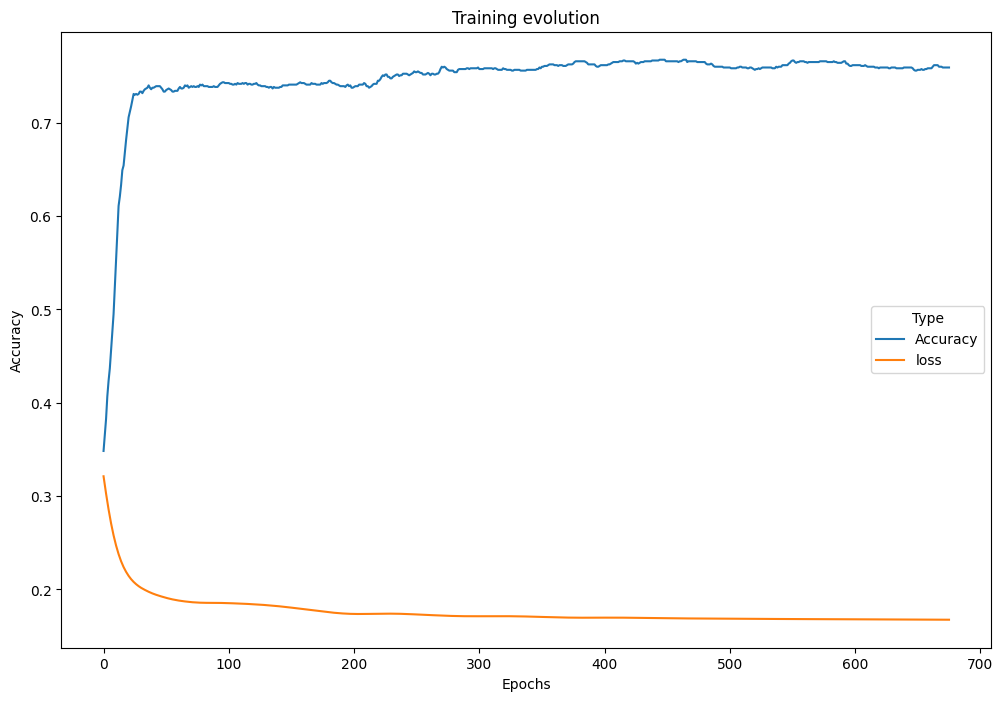

In [30]:

history_dict = resultado.history

# Check available keys
available_metrics = list(history_dict.keys())
print("Metrics available:", available_metrics)

plot_data = []

# Check if accuracy and loss keys are available
if 'Accuracy' in available_metrics:
    plot_data.append('Accuracy')
if 'loss' in available_metrics:
    plot_data.append('loss')

if plot_data:
    # Transform data into dataframe
    history_df = pd.DataFrame({key: history_dict[key] for key in plot_data})
    history_df['epoch'] = history_df.index

    history_long = history_df.melt(id_vars='epoch', value_vars=plot_data, 
                                   var_name='Type', value_name='accuracy')

    plt.figure(figsize=(12, 8))
    seaborn.lineplot(data=history_long, x='epoch', y='accuracy', hue='Type')
    plt.title('Training evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(title='Type')
    plt.show()
else:
    print("No metrics found")